In [130]:
import os
import re
import os
import tempfile
import math
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "",  bow_docs_pos = None, dictionary_pos = None, texts_pos = None, filenames = None, limit = 10000, paragraphs = False):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    if(bow_docs_pos == None):
        bow_docs_pos = []
        texts_pos = []
        dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging
        filenames = []
    bow_docs_common = []
    texts_common = []
    dictionary_common = Dictionary()   # Dictionary based on common words


    print("Building dictionaries\n")
    #print("Files")
    #print(filenames)

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    if paragraphs:
                        paragraph_list = email_dict['body_pos_paragraph_tokens']
                        if len(paragraph_list) > 0:
                            for paragraph in paragraph_list:
                                texts_pos.append(paragraph)
                                dictionary_pos.add_documents([paragraph])
                                bow_docs_pos.append(dictionary_pos.doc2bow(paragraph))
                                #print(email_file)
                                filenames.append(email_file)
                                
                    else:
                        texts_common.append(email_dict['body_tokens'])
                        dictionary_common.add_documents([email_dict['body_tokens']])
                        bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                        # Build a specialised POS dictionary and BOW
                        if(email_dict["body_pos_tokens"] != None):
                            texts_pos.append(email_dict["body_pos_tokens"])
                            dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                            bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))
                            filenames.append(email_file)

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,filenames

### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)

    return model

#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model,filename = ''):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()
        if filename != '':
            topic_filename = filename + '_topic_' + str(topic_nr + 1) + '.png'
            print('Saving: ',topic_filename)
            cloud.to_file(topic_filename)
            
# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True,
                store_models = False, prefix='', num_topics_list = None):

    scores = []
    if num_topics_list is None:
        num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
        num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    else:
        num_topics_subset = num_topics_list
        
  
        
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            #if store_models:
            #    with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
            #                                     dir=tmpdir,delete=False) as tmp:
            #        lda.save(tmp.name)
            pbar.update(1)
    
    if store_models:
        tmpdir = tempfile.mkdtemp(prefix = prefix + '_',dir = '.')     #Create a directory to save the models
        score_pairs = {}
        for score in scores:
            num_topics,score,model = score       #Extract the three elements
            with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
                                             dir=tmpdir,delete=False) as tmp:
                    model.save(tmp.name)
            score_pairs[num_topics] = score
        
        with tempfile.NamedTemporaryFile(mode='w', prefix=prefix + '_scores_', suffix = '.json',
                                         dir=tmpdir,delete=False) as tmp:
            print(score_pairs)
            json.dump(score_pairs,tmp)

    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='Scores'))
    if reference != 0:
        fig.add_scatter(x=[reference]*100, y=np.linspace(min,max,100), name='Reference point')
    fig.show()





def vectorise(topic_scores,nr_topics):
    vector = [0] * nr_topics
    
    for score in topic_scores:
        vector[score[0]] = score[1]
    return vector

def dot_product(vector1,vector2):
    dot_product_sum = 0
    vector1_sum = 0
    vector2_sum = 0
    
    for v1,v2 in zip(vector1,vector2):
        dot_product_sum = dot_product_sum + (v1*v2)
        vector1_sum = vector1_sum + v1*v1
        vector2_sum = vector2_sum + v2*v2
        
    vector_product = round(dot_product_sum,20) / round(math.sqrt(vector1_sum) * math.sqrt(vector2_sum),20)
    return (round(vector_product,5))

def cosine_sim(vector1,vector2):
    vector_product = dot_product(vector1,vector2)
    try:
        angle_radians = math.acos(vector_product)
    except:
        print(vector_product)
        if(vector_product > 1.0):
            vector_product = 1.0
            angle_radians = math.acos(vector_product)
    return math.degrees(angle_radians)

def simialarity(score1,score2,nr_topics):
    vector1 = vectorise(score1,nr_topics)
    vector2 = vectorise(score2,nr_topics)
    angle = cosine_sim(vector1,vector2)
    percentage_simialarity = 100 * (90-angle) / 90
    return percentage_simialarity

def extract_model(scored_models, no_topics):
    model = None
    for scored_model in scored_models:
        if scored_model[0] == no_topics:
            model = scored_model
    return model

def store_scored_models(models_list, path, file_prepend):
    for scored_reference in models_list:
        print(scored_reference)
        filename = path + file_prepend + str(scored_reference[0])
        coherence_score = scored_reference[1]
        model = scored_reference[2]
        print(filename)
        model.save(filename)


def load_scored_model(path,file_prepend, no_topics,texts,dictionary):
    filename = path + file_prepend +str(no_topics)
    print('Loading model:',filename)
    stored_model = LdaModel.load(filename)
    print('Scoring model')
    coherence_model_lda = CoherenceModel(model=stored_model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
    coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
    print('Model score:', coherence_lda)
    print()
    return (no_topics,coherence_lda,stored_model)


def score_query(filename, model, dictionary):
    # Load the query email and convert it to tokens.
    email = loadMail(query_email_filename)
    
    bow = []
    #Load the email and convert to BOW
    if(email["body_pos_tokens"] != None):
        bow.append(dictionary.doc2bow(email["body_pos_tokens"]))
        score = model[2][bow[0]]
    return score

def score_mails(reference_model, query_email_scores, dictionary, texts, files, ranked = True):

    score_dictionary = {}
    file_mapping = {}
    email_nr = 0
    with tqdm(total=len(texts)) as pbar:
        for tokens,filename in zip(texts,files):
            email_nr = email_nr + 1

            model = reference_model[2]     # Extract the model
            bow = dictionary.doc2bow(tokens)
            document_score = model[bow]    # Score the email

            if len(document_score) == 0:
                sim = 0.0
            else:
                sim = simialarity(query_email_scores,document_score,reference_model[0])  #Calculate simialarity to query email
            #email_simialarity_scores[index].append(sim)   # Store the simialarity in order of scoring
            score_dictionary[email_nr] = sim              # Store similariy in dictionary, with key posisition in scoring
            file_mapping[email_nr] = filename
            pbar.update(1)
 
    if ranked:
        score_dictionary = sorted(score_dictionary.items(),key=lambda x: x[1], reverse = True)
        
    return score_dictionary,file_mapping

def extract_top_results(ranked_emails, file_mapping, top):
    
    unique_ranking = 1
    overall_cnt = 0
    extracted_filenames = {}
    for email in ranked_emails:
        #overall_cnt = overall_cnt + 1
        index = email[0]
        score = email[1]
        if score != 0.0:
            #filename = os.path.basename(file_mapping[index])
            if file_mapping[index] not in extracted_filenames:
                extracted_filenames[file_mapping[index]] = unique_ranking
                unique_ranking = unique_ranking + 1
                if (unique_ranking - 1) == top:
                    break
            #print(filename,score)
    #print(unique_ranking - 1,overall_cnt)
    return(extracted_filenames)

def calculate_correct_hits(results,file_prepend):
    hits = 0
    misses = 0
    zeros = 0
    for result in results:
        filename = os.path.basename(result)
        if file_prepend in filename:
            hits = hits + 1
        else:
            misses = misses + 1
    return hits,misses



In [23]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p') 
#subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 

multex_subdir = os.path.join('..','..','data', 'processed', 'Multex')



########## End Initialisation Section ##########


# Build the dictionaries
print('Building paragraph dictionaries')
_,_,_,par_bow,par_dictionary,par_texts,par_files = build_dictionaries(multex_subdir,pre_pend_filter = "", paragraphs=True)
#print(par_files)
_,_,_,par_bow,par_dictionary,par_texts,par_files = build_dictionaries(subdir,pre_pend_filter = "Full_", paragraphs=True, bow_docs_pos = par_bow, dictionary_pos = par_dictionary, texts_pos = par_texts, filenames = par_files)
#print(par_files)

print('Building normal dictionaries')
_,_,_,email_bow,email_dictionary,email_texts,email_files = build_dictionaries(multex_subdir,pre_pend_filter = "", paragraphs=False)
_,_,_,email_bow,email_dictionary,email_texts,email_files = build_dictionaries(subdir,pre_pend_filter = "Full_", paragraphs=False, bow_docs_pos = email_bow, dictionary_pos = email_dictionary, texts_pos = email_texts, filenames = email_files)
#print(email_files)



Building paragraph dictionaries
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  0
Number of documents in the POS corpus:  8284
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  0
Number of documents in the POS corpus:  30015
Building normal dictionaries
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  149
Number of documents in the POS corpus:  149
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3183


100%|████████████████████████████████████████████| 9/9 [33:30<00:00, 223.38s/it]


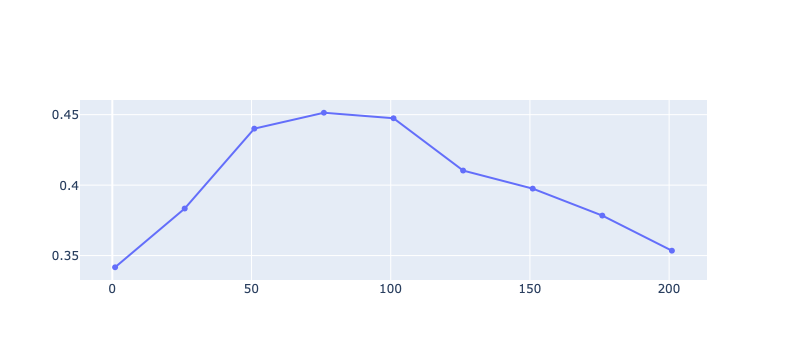

100%|████████████████████████████████████████| 61/61 [6:45:18<00:00, 398.67s/it]


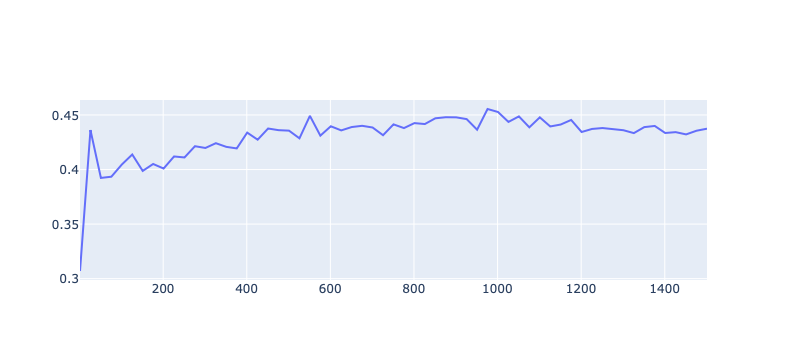

In [44]:
par_scores = score_topics(par_dictionary, par_bow, par_texts, start = 1, step = 25, stop = 203)
    
plot_topic_scores(par_scores)

email_scores = score_topics(email_dictionary, email_bow, email_texts, start = 1, step = 25, stop = 1503)
    
plot_topic_scores(email_scores)



(976, 0.4554753892867113, <gensim.models.ldamodel.LdaModel at 0x136a762b0>)

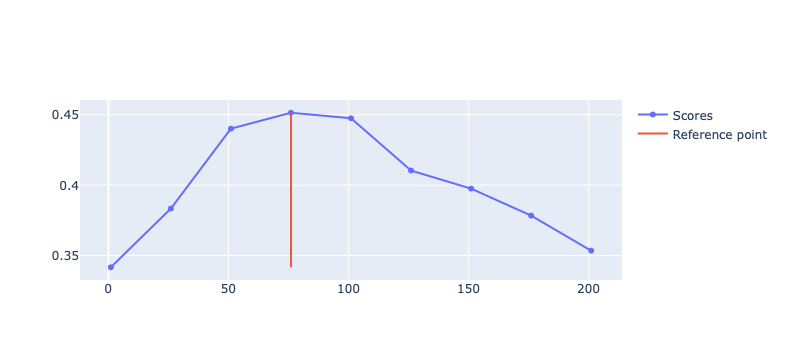

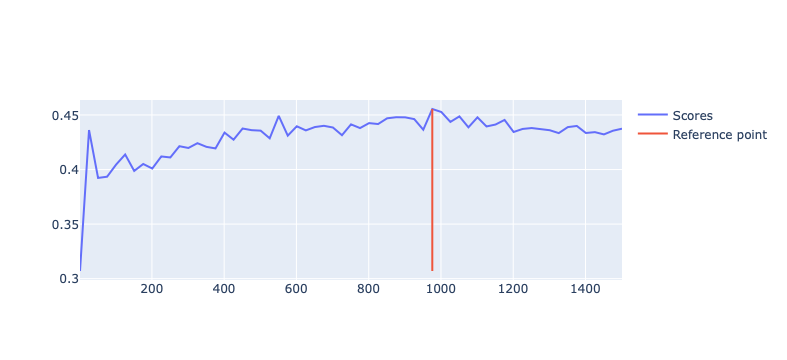

(76, 0.4513493494589726, <gensim.models.ldamodel.LdaModel object at 0x12303a670>)
(976, 0.4554753892867113, <gensim.models.ldamodel.LdaModel object at 0x136a762b0>)


In [64]:
plot_topic_scores(par_scores,reference = 76)
plot_topic_scores(email_scores,reference = 976)

no_topics_par = 76
no_topics_email = 976

par_model = extract_model(par_scores, no_topics_par)
email_model = extract_model(email_scores, no_topics_email)

print(par_model)
print(email_model)

In [65]:

store_scored_models(par_scores, 'stored_models_experiment3/','paragraph_')
store_scored_models(email_scores, 'stored_models_experiment3/','full_email_')



(1, 0.3417039061174385, <gensim.models.ldamodel.LdaModel object at 0x13365ed30>)
stored_models_experiment3/paragraph_1
(26, 0.38337750381339636, <gensim.models.ldamodel.LdaModel object at 0x13365eb50>)
stored_models_experiment3/paragraph_26
(51, 0.4400744589099817, <gensim.models.ldamodel.LdaModel object at 0x122d2f0d0>)
stored_models_experiment3/paragraph_51
(76, 0.4513493494589726, <gensim.models.ldamodel.LdaModel object at 0x12303a670>)
stored_models_experiment3/paragraph_76
(101, 0.4474538366718189, <gensim.models.ldamodel.LdaModel object at 0x12b2a1fd0>)
stored_models_experiment3/paragraph_101
(126, 0.41033283198414927, <gensim.models.ldamodel.LdaModel object at 0x1295e0f70>)
stored_models_experiment3/paragraph_126
(151, 0.39750473038948464, <gensim.models.ldamodel.LdaModel object at 0x123003040>)
stored_models_experiment3/paragraph_151
(176, 0.3783745746184822, <gensim.models.ldamodel.LdaModel object at 0x12905dfd0>)
stored_models_experiment3/paragraph_176
(201, 0.353452092972846

In [34]:
no_topics_par = 76
no_topics_email = 976

par_model = load_scored_model('stored_models_experiment3/','paragraph_', no_topics_par, par_texts, par_dictionary)    
email_model = load_scored_model('stored_models_experiment3/','full_email_', no_topics_email, email_texts, email_dictionary)    


print(par_model)
print(email_model)


Loading model: stored_models_experiment3/paragraph_76
Scoring model
Model score: 0.4513493494589726

Loading model: stored_models_experiment3/full_email_976
Scoring model
Model score: 0.4554753892867113

(76, 0.4513493494589726, <gensim.models.ldamodel.LdaModel object at 0x123123850>)
(976, 0.4554753892867113, <gensim.models.ldamodel.LdaModel object at 0x123c36040>)


In [62]:
# Select a query email and score it.

query_email_filename = os.path.join(multex_subdir,'Multex_1.json')

par_query_score = score_query(query_email_filename, par_model, par_dictionary)
email_query_score = score_query(query_email_filename, email_model, email_dictionary)


In [129]:

print('Model: email - Document: email')
ranked_emails_email_email,file_mapping_email_email  = score_mails(email_model, email_query_score, email_dictionary, email_texts, email_files)

print('Model: email - Document: paragraphs')
ranked_emails_email_par,file_mapping_email_par  = score_mails(email_model, email_query_score, email_dictionary, par_texts, par_files)

print('Model: paragraphs - Document: email')
ranked_emails_par_email,file_mapping_par_email  = score_mails(par_model, par_query_score, par_dictionary, email_texts, email_files)

print('Model: paragraphs - Document: paragraphs')
ranked_emails_par_par,file_mapping_par_par  = score_mails(par_model, par_query_score, par_dictionary, par_texts, par_files)



Model: email - Document: email


100%|██████████████████████████████████████| 3183/3183 [00:16<00:00, 187.49it/s]


Model: email - Document: paragraphs


100%|████████████████████████████████████| 30015/30015 [02:16<00:00, 220.20it/s]


Model: paragraphs - Document: email


100%|██████████████████████████████████████| 3183/3183 [00:03<00:00, 863.89it/s]


Model: paragraphs - Document: paragraphs


100%|███████████████████████████████████| 30015/30015 [00:20<00:00, 1450.49it/s]


In [139]:
top_results = extract_top_results(ranked_emails_email_email, file_mapping_par_par, 150)
hits,misses = calculate_correct_hits(top_results,'Multex')
print(len(top_results))
print(hits,misses)
print()


top_results = extract_top_results(ranked_emails_email_par, file_mapping_par_par, 150)
hits,misses = calculate_correct_hits(top_results,'Multex')
print(len(top_results))
print(hits,misses)
print()


top_results = extract_top_results(ranked_emails_par_email, file_mapping_par_par, 150)
hits,misses = calculate_correct_hits(top_results,'Multex')
print(len(top_results))
print(hits,misses)
print()


top_results = extract_top_results(ranked_emails_par_par, file_mapping_par_par, 150)
hits,misses = calculate_correct_hits(top_results,'Multex')
print(len(top_results))
print(hits,misses)
print()





16
16 0

141
123 18

55
55 0

150
118 32

